In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset, BatchSampler, SequentialSampler, Sampler

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_embeddings(vectors, y=None):
    
    # reduce dimensions with TSNE
    trans_vectors = TSNE(
        n_components=2, learning_rate='auto', init='random', perplexity=5
    ).fit_transform(vectors)
    
    # create legend if labels are known
    colors = None
    if y is not None:
        
        # create color map from unique labels
        labels = np.unique(y)
        label_idx = {k: v for k, v in zip(labels, range(len(labels)))}
        cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
        colors = [cmap(label_idx[i]) for i in y]
        
        # add legend labels manually
        patches = [mpatches.Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]
        plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.scatter(
        trans_vectors[:, 0],
        trans_vectors[:, 1],
        c=colors, alpha=1
    )
    return

def cutpad(arr):
    """
    Removes padding from array
    """
    return arr[arr != 0]

In [3]:
spec_cols = ['supplier_status', 'volume_contracted', 'spec_price', 'delivery_period_lenght']
delivery_cols = ['price_change', 'lateness_percentage', 'weight_percentage']
time_cols = ['month', 'day', 'weekday']

In [5]:
data.head(3)

,supplier,id,supplier_status,volume_contracted,spec_price,delivery_period_lenght,price_change,lateness_percentage,weight_percentage,month,day,weekday
0,Рязанова А.В. ИП Глава К(Ф)Х,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,0,-0.799088,-0.254878,-1.951154,0.455259,0.0,0.914667,7,6,2
1,Осипов Л.А. ИП Глава К(Ф)Х,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",1,-0.722675,-0.254878,-1.369456,0.263534,0.0,0.184882,7,12,1
2,Осипов Л.А. ИП Глава К(Ф)Х,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",1,-0.722675,-0.254878,-1.369456,0.480267,0.0,0.363412,7,12,1


In [80]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, spec_cols, series_cols, time_cols):
        self.df = df
        self.spec_cols = spec_cols
        self.series_cols = series_cols
        self.time_cols = time_cols
        self.specs = df['id'].unique()
        self.supplier = [
            df.loc[df['id'] == spec_id]['supplier'].iloc[0]
            for spec_id in self.specs
        ]

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        data = self.df.loc[self.df['id'] == self.specs[idx]]
        
        h = torch.tensor(data[self.spec_cols].iloc[0].values, dtype=torch.float)
        x = torch.tensor(data[self.series_cols].values, dtype=torch.float)
        t = torch.tensor(data[self.time_cols].values, dtype=torch.float)
        
        return h, x, t

def pad_collate(batch):
    max_len = max([len(sample[1]) for sample in batch])
    new_batch = []
    for sample in batch:
        repeat_n = max_len - len(sample[1])
        
        sample_h = sample[0]
        sample_x = torch.cat((sample[1], sample[1][-1].unsqueeze(0).repeat(repeat_n, 1)))
        sample_t = torch.cat((sample[2], sample[2][-1].unsqueeze(0).repeat(repeat_n, 1)))
        
        new_batch.append((
            sample_h, 
            sample_x,
            sample_t
        ))
    
    h = torch.stack([sample[0] for sample in new_batch])
    x = torch.stack([sample[1] for sample in new_batch])
    t = torch.stack([sample[2] for sample in new_batch])
    return h, x, t

In [81]:
class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Seq2SeqAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden = hidden.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        output, _ = self.decoder(hidden)
        return output

In [82]:
data = pd.read_csv('../data/final_data/data.csv')
dataset = TimeSeriesDataset(data, spec_cols, delivery_cols, time_cols)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=pad_collate, shuffle=False)

In [11]:
model = Seq2SeqAutoencoder(5, 10, 1)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [13]:
for epoch in range(500):
    for sequences in dataloader:
        output = model(sequences)
        loss = criterion(output, sequences)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print(loss.item())

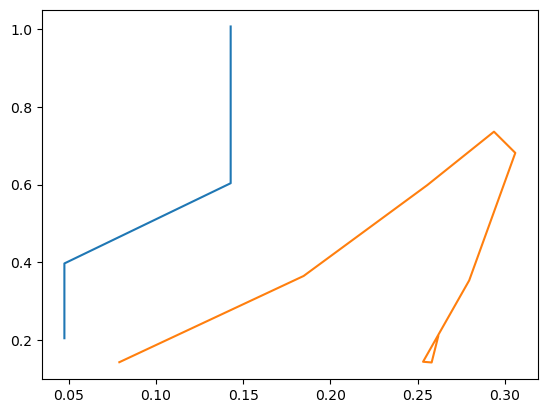

In [43]:
i = 5
plt.plot(cutpad(sequences[i, :, -2]), cutpad(sequences[i, :, -1]))
plt.plot(cutpad(output[i, :, -2].detach()), cutpad(output[i, :, -1].detach()))

In [18]:
supplier_set = {
    'Барсукова Е.С. ИП Глава К(Ф)Х',
    'Донченко В.С. ИП Глава К(Ф)Х',
    'АГРОПРОМ ООО', 'ИНТЕРПРОМ ООО', 'ДОНСКИЕ ЗОРИ ООО'
}
indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [19]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

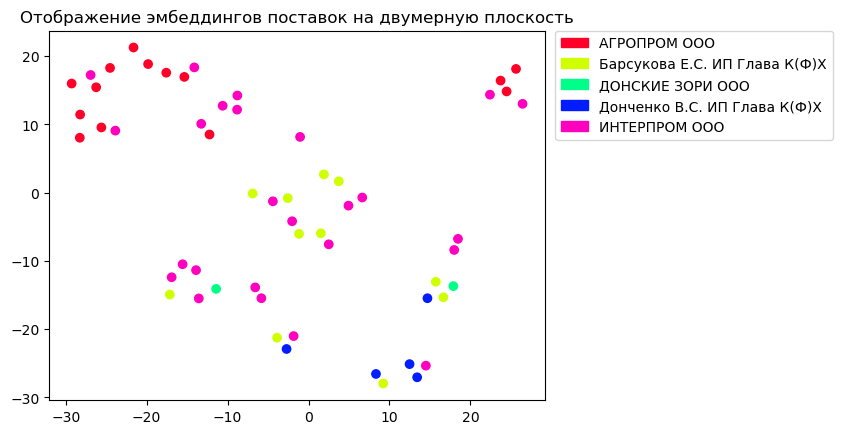

In [21]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [117]:
class LengthBatchSampler(BatchSampler):
    def __iter__(self):
        indices = np.arange(len(self.sampler))
        np.random.shuffle(indices)
        bins = [indices[i:i + self.batch_size] for i in range(0, len(indices), self.batch_size)]
        sorted_bins = sorted(bins, key=lambda x: max(len(self.sampler.data[j]) for j in x))
        batch_indices = [item for sublist in sorted_bins for item in sublist]
        yield from torch.split(torch.tensor(batch_indices), self.batch_size)

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def pad_collate(batch):
    max_len = max([len(sample[0]) for sample in batch])
    return (
        torch.stack([torch.cat((
            X_i, torch.zeros(
                tuple(max_len-size if i==0 else size for i, size in enumerate(X_i.shape)),
                dtype=torch.float
            )
        )) for X_i, _ in batch]),
        torch.stack([y_i for _, y_i in batch])
    )

In [118]:
data = [
    torch.tensor([1, 2, 3]),
    torch.tensor([1, 2, 3, 4, 5]),
    torch.tensor([1, 2]),
    torch.tensor([1, 2, 3, 4]),
    # Add more sequences...
]
labels = torch.tensor([
    1,
    0,
    1,
    0,
    # Add more labels...
])

dataset = MyDataset(data, labels)
# batch_sampler = LengthBatchSampler(SequentialSampler(dataset), batch_size=2)
# dataloader = DataLoader(dataset, batch_size=2,
#                         # batch_sampler=batch_sampler,
#                         collate_fn=pad_collate)

In [93]:
X, y = next(iter(dataloader))

In [123]:
class BucketBatchSampler(torch.utils.data.Sampler):
    def __init__(self, lengths, batch_size, shuffle=True):
        self.indices = torch.argsort(lengths)
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            batch = []
            for index in self.indices[torch.randperm(len(self.indices))]:
                batch.append(index)
                if len(batch) == self.batch_size:
                    yield batch
                    batch = []
            if len(batch) > 0:
                yield batch
        else:
            return iter(self.indices[i:i+self.batch_size] for i in range(0, len(self.indices), self.batch_size))

    def __len__(self):
        return len(self.indices)

In [124]:
lengths = torch.tensor([len(item) for item in data])
sampler = BucketBatchSampler(lengths, batch_size=2)
loader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler, collate_fn=pad_collate)

In [125]:
lengths

tensor([3, 5, 2, 4])

In [126]:
X, y = next(iter(loader))

In [127]:
X

tensor([[1., 2., 0., 0.],
        [1., 2., 3., 4.]])

In [133]:
for X, y in loader:
    print(X)

tensor([[1., 2., 3., 4., 0.],
        [1., 2., 3., 4., 5.]])
tensor([[1., 2., 3.],
        [1., 2., 0.]])
